# Set-up

In [43]:
import os
import sys
import pandas as pd
import numpy as np
from scipy import io

In [44]:
# Set wd
os.chdir("/cellar/users/aklie/data/datasets/deAlmeida_DrosophilaS2_UMI-STARR-seq")

In [45]:
# Set fold to train on
log_dir = f"models/2023_12_19/seqdatasets/LASSO"

# Load sequence TF features

In [46]:
# 
fasta_file = "analysis/2023_11_26/seqdatasets/Sequences_Train.fa"
activities = pd.read_csv("analysis/2023_11_26/seqdatasets/Sequences_activity_Train.txt", sep="\t")
with open(fasta_file, "r") as f:
    fasta = f.readlines()
ids = [i.strip().replace(">", "") for i in fasta if i.startswith(">")]
activities.index = ids

In [47]:
mtx = io.mmread("training/2023_12_19/seqdatasets/motifCounts_df.mtx")
rownames = pd.read_csv("training/2023_12_19/seqdatasets/motifCounts_df_row_names.txt", sep="\t", header=None)
rownames = rownames[0].tolist()
colnames = pd.read_csv("training/2023_12_19/seqdatasets/motifCounts_df_col_names.txt", sep="\t", header=None)
colnames = colnames[0].tolist()
rownames[:5], colnames[:5]

(['chr2L_4993801_4994049_-_negative',
  'chr3R_4714668_4714916_-_peak_849bp_region',
  'chrX_5573402_5573650_-_peak_849bp_region',
  'chr2L_12461310_12461558_+_peak_849bp_region',
  'chr2L_13741449_13741697_-_peak_849bp_region'],
 ['bergman__Abd-B',
  'bergman__Adf1',
  'bergman__Aef1',
  'bergman__Cf2',
  'bergman__Dip3'])

In [48]:
tf_df = pd.DataFrame(mtx.todense(), index=rownames, columns=colnames)

In [49]:
y_train = activities.loc[tf_df.index]["Dev_log2_enrichment"].values
X_train = tf_df.values
X_train.shape, y_train.shape

((40000, 6502), (40000,))

# Instantiate the model

In [50]:
from sklearn.linear_model import Lasso

In [57]:
# Perform cross fold validation to find best alpha
from sklearn.model_selection import GridSearchCV

# Set up the grid
alphas = np.logspace(-4, 4, 20)
param_grid = {"alpha": alphas}
grid_search = GridSearchCV(Lasso(), param_grid, cv=10, scoring="neg_mean_squared_error", return_train_score=True)

# Fit the grid
grid_search.fit(X_train, y_train)

# Get the best estimator
lasso = grid_search.best_estimator_
lasso

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e+04, tolerance: 8.365e+00
  model = cd_fast.enet_coordinate_descent(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.944e+04, tolerance: 8.432e+00
  model = cd_fast.enet_coordinate_descent(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, c

In [51]:
module = Lasso(alpha=0.1, max_iter=10000, tol=0.0001, selection="random", random_state=1234)

In [52]:
module.fit(X_train, y_train)

Lasso(alpha=0.1, max_iter=10000, random_state=1234, selection='random')

In [53]:
# Look at training performance
y_pred = module.predict(X_train)
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
r2 = r2_score(y_train, y_pred)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
pearson = pearsonr(y_train, y_pred)[0]
print(f"R2: {r2}")
print(f"RMSE: {rmse}")
print(f"Pearson: {pearson}")

R2: 0.21851004383509076
RMSE: 1.3471790121497038
Pearson: 0.4787053510187852


In [54]:
sys.path.append('/cellar/users/aklie/data/datasets/deAlmeida_DrosophilaS2_UMI-STARR-seq/bin/model_evaluation')
from eval import scatter, auroc, auprc

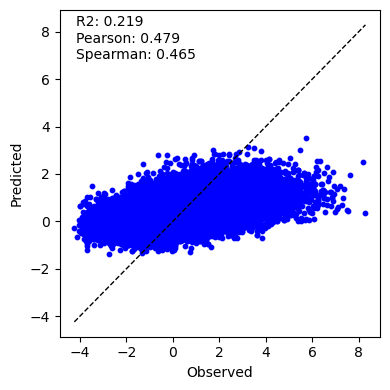

In [55]:
scatter(
    x=y_train,
    y=y_pred,
    rasterized=True,
)

# DONE!

---